# Bayesian Belief Networks(BBN)
---
While Naive Bayes is built on the assumption that all variables are independent, which is often not true.
In some cases you may want to build a model where you can specify which variables are dependent, independent, or ***conditionally independent***  (semi-supervised). 

We simply define how different nodes in the network ar linked together.

Bayesian Belief Network (BBN) is a probabilistic graphical method(PGM) that represents a set of variables and their conditional dependencies via a Directed Acrylic graph(DAG)

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [14]:
df = pd.read_csv('../data/weatherAUS.csv')

df=df[pd.isnull(df['RainTomorrow'])==False]

df=df.fillna(df.mean())

df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else
                                                            '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')


In [15]:
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), [0.30658, 0.69342])
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), [0.92827, 0.07173, 
                                                      0.55760, 0.44240])
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), [0.58660, 0.24040, 0.17300])
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), [0.92314, 0.07686, 
                                                0.89072, 0.10928, 
                                                0.76008, 0.23992, 
                                                0.64250, 0.35750, 
                                                0.49168, 0.50832, 
                                                0.32182, 0.67818])

In [16]:
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            if parent2==None:
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [17]:
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

join_tree = InferenceController.apply(bbn)

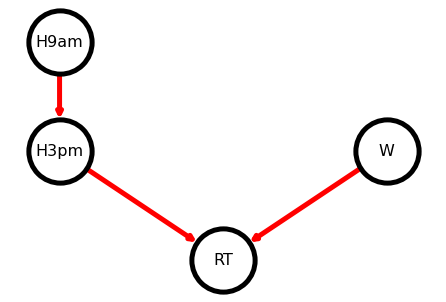

In [22]:
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [23]:
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.00000
1=>60|1.00000
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.00000
0=>60|1.00000
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.00000
2=40-50|0.00000
2=>50|1.00000
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.32182
3=Yes|0.67818
----------------


In [24]:
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
evidence('ev1', 'H9am', '>60', 1.0)

print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.00000
1=>60|1.00000
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.06689
0=>60|0.93311
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.00000
2=40-50|0.00000
2=>50|1.00000
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.32182
3=Yes|0.67818
----------------


In [26]:
evidence('ev1', 'H3pm', '>60', 1.0)
evidence('ev2', 'W', '>50', 1.0)
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.00000
1=>60|1.00000
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.06689
0=>60|0.93311
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.00000
2=40-50|0.00000
2=>50|1.00000
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.32182
3=Yes|0.67818
----------------
